# Loan Approval Classifier Project
---

In [8]:
#All the imports

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
 

---
### Now lets load the dataset and take a look at the first few rows.
---

In [2]:
loanDB = pd.read_csv('../../data/loan_data.csv')
loanDB.head(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


---
- our target variable is 'loan_status' which indicates whether the loan was approved or not.
---

In [3]:
print(loanDB.shape)
loanDB.info()

(45000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaul

C:\Users\AbdulHadiSaqib\AppData\Local\Temp\ipykernel_7600\2083404105.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values, ax=axes[i], palette='pastel')
C:\Users\AbdulHadiSaqib\AppData\Local\Temp\ipykernel_7600\2083404105.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.values, ax=axes[i], palette='pastel')
C:\Users\AbdulHadiSaqib\AppData\Local\Temp\ipykernel_7600\2083404105.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages.index, y=percentages.

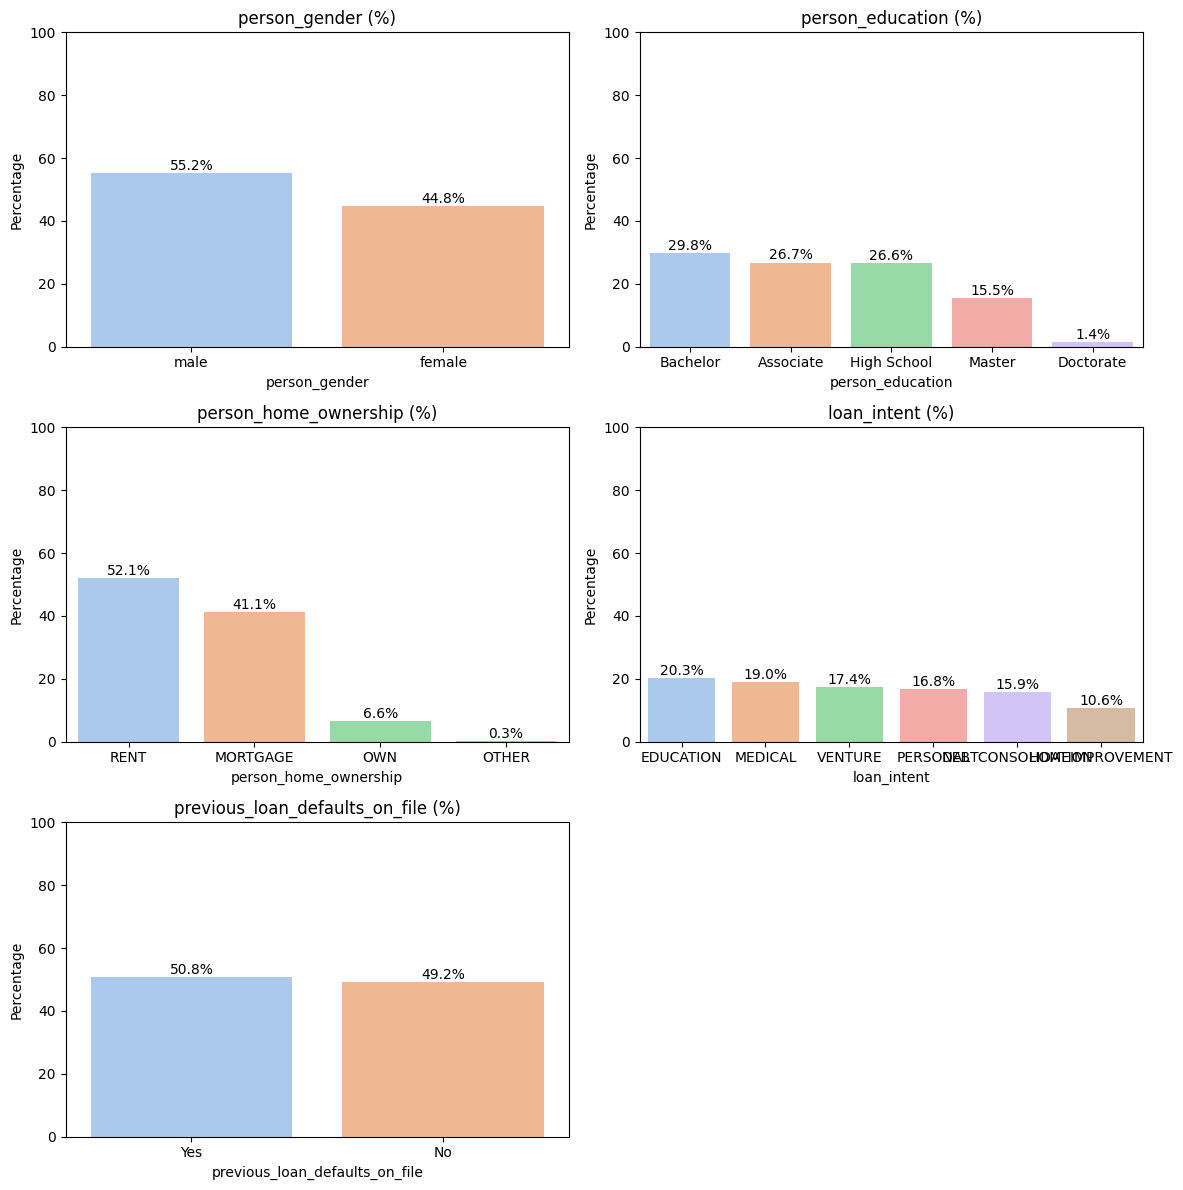

In [4]:

demographics = loanDB[loanDB.select_dtypes(include=['object']).columns]
n_cols = 2  # Number of columns in subplot grid
n_rows = int(np.ceil(len(demographics.columns) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(demographics.columns):
    percentages = loanDB[col].value_counts(normalize=True) * 100
    sns.barplot(x=percentages.index, y=percentages.values, ax=axes[i], palette='pastel')
    axes[i].set_title(f"{col} (%)")
    axes[i].set_ylabel('Percentage')
    axes[i].set_ylim(0, 100)
    for j, v in enumerate(percentages.values):
        axes[i].text(j, v + 1, f"{v:.1f}%", ha='center')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Now lets check for na and remove if they exist

In [7]:
loanDB.isnull().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

## More insights of the dataset


In [6]:
object_features = loanDB.select_dtypes(include=['object']).columns.tolist()
print(object_features)

['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']


In [7]:
loanDB[object_features]

,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file
0,female,Master,RENT,PERSONAL,No
1,female,High School,OWN,EDUCATION,Yes
2,female,High School,MORTGAGE,MEDICAL,No
3,female,Bachelor,RENT,MEDICAL,No
4,male,Master,RENT,MEDICAL,No
...,...,...,...,...,...
44995,male,Associate,RENT,MEDICAL,No
44996,female,Associate,RENT,HOMEIMPROVEMENT,No
44997,male,Associate,RENT,DEBTCONSOLIDATION,No
44998,male,Bachelor,RENT,EDUCATION,No


---
- will apply binary encoding in : gender and previous loan status
- And will apply  Ordinal Encoding on: education
- While one hot on the rest of the columns
---

Text(0.5, 1.0, 'Correlation Matrix')

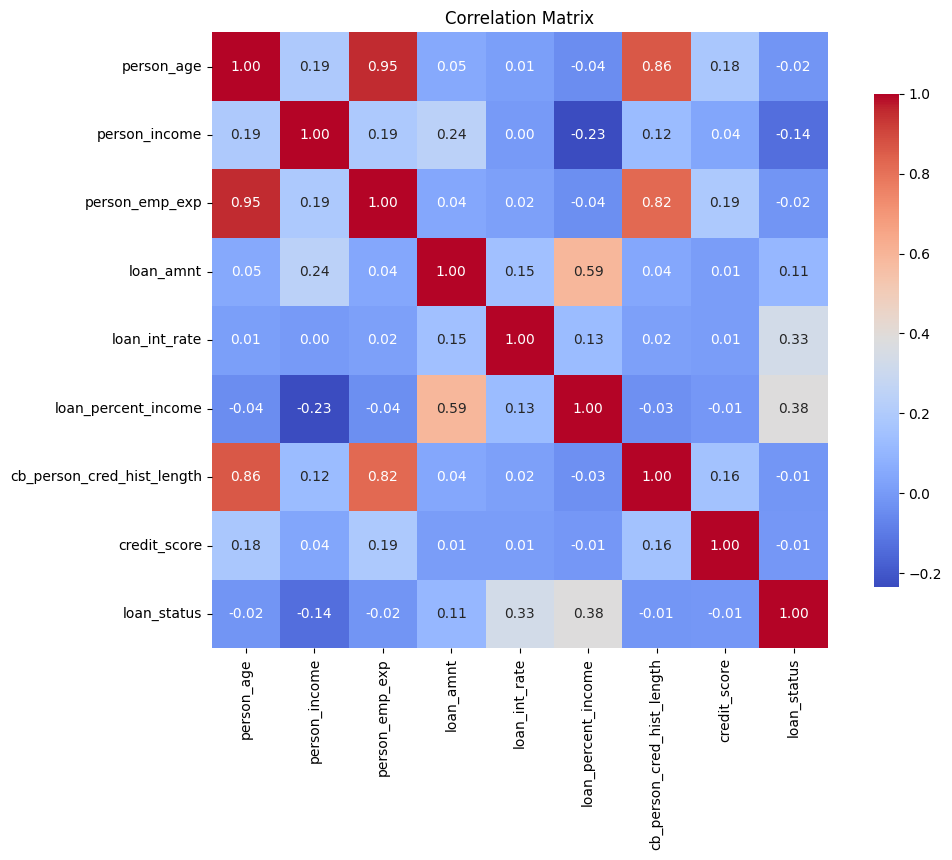

In [13]:
numerical_features = loanDB.select_dtypes(include=np.number).columns.tolist()

corr_matrix = loanDB[numerical_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix")
